In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np

In [20]:
torch.cuda.is_available()
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

## Modelo proposto por Murray

Modelo proposto por Murray, por volta de 1990. Este modelo levou em conta que gliomas raramente realizam metastaze para fora do cérebro. A fim de simplificar a definição de cancer como uma proliferação desordenada de células e uma invasão local, ele assumiu que a difusão das células cancerígenas como o gradiente de acordo com a lei de Fick, expressando, posteriormente, de forma matemática através da seguinte relação

$$
\dfrac{\partial c}{\partial t} = \bigtriangledown \cdot (\bigtriangledown c) + pc 
$$

onde:
- $c(x,t)$: Concentração de células tumorais por mm³
- $D$: Coeficiente de difusão dado em mm²/dia (representa a mortalidade da célula)
- $p$: Taxa de proliferação em 1/dia

In [21]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

In [22]:
#PARAMETROS
D = 0.0013
p = 0.12
L = 2.0
c0 = 8e4

Dl = D / (p * L**2)

#DOMINIO ESPACIAL E TEMPORAL
x_dom = (0, 1)
t_dom = (0, 20)

#ADIMENSIONALIZAÇÃO
batch_size = 1000
x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_().to(device)
t = torch.FloatTensor(batch_size).uniform_(t_dom[0], t_dom[1]).requires_grad_().to(device)


#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def DifusaoReacao(x, t, model):

    input = torch.stack((x, t),1)
    c = model(input)

    cl = (c * L**3) / c0

    c_t = torch.autograd.grad(cl.sum(), t, create_graph = True)[0]
    c_x = torch.autograd.grad(cl.sum(), x, create_graph = True)[0]

    c_xx = torch.autograd.grad(c_x.sum(), x, create_graph = True)[0]
    
    return c_t - (Dl * c_xx - cl)

#VALORES DE ENTRADA
x0 = torch.tensor([L], dtype=torch.float32).to(device)
t0 = torch.tensor([0.], dtype=torch.float32).to(device)

#PREPARAÇÃO DOS DADOS
input_pde = torch.cartesian_prod(x, t).to(device)
input_ic1 = torch.cartesian_prod(x, t0).to(device)
input_ic2 = torch.cartesian_prod(x0, t).to(device)
ic_target = L**3 * torch.exp(-100 * x**2).to(device)

#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(2, 1, 80, 1, torch.nn.Tanh()).to(device) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
epochs = 5000
optmizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-3,
)
loss_fn = torch.nn.MSELoss()

In [23]:
#TREINAMENTO

l1_map = []
l2_map = []
l3_map = []
l_map = []

for ep in range(epochs):
    

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_ic= model(input_ic1)
    l1 = loss_fn(out_ic, ic_target)

    out_ic= model(input_ic2)
    ic_target2 = torch.zeros_like(out_ic)
    l2 = loss_fn(out_ic, ic_target2)

    #CALCULO DO CUSTO PARA A EDP
    out_pde= DifusaoReacao(x, t, model)
    pde_target = torch.zeros_like(out_pde)
    l3 = loss_fn(out_pde, pde_target)

    l1_map.append(l1.item())
    l2_map.append(l2.item())
    l3_map.append(l3.item())
    
    #BACKPROPAGATION
    loss = l1 + l2 + l3
    l_map.append(loss.item())

    loss.backward(retain_graph=True)
    optmizer.step()
    optmizer.zero_grad()

    with torch.autograd.no_grad():
        print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')
    
model.eval()

Epochs: 0/5000 Loss: 3.8063743114471436
Epochs: 1/5000 Loss: 3.6701419353485107
Epochs: 2/5000 Loss: 3.544363498687744
Epochs: 3/5000 Loss: 3.4356908798217773
Epochs: 4/5000 Loss: 3.3647005558013916
Epochs: 5/5000 Loss: 3.3062682151794434
Epochs: 6/5000 Loss: 3.2478415966033936
Epochs: 7/5000 Loss: 3.196765422821045
Epochs: 8/5000 Loss: 3.156168222427368
Epochs: 9/5000 Loss: 3.1198232173919678
Epochs: 10/5000 Loss: 3.0827796459198
Epochs: 11/5000 Loss: 3.0462405681610107
Epochs: 12/5000 Loss: 3.0134024620056152
Epochs: 13/5000 Loss: 2.984931230545044
Epochs: 14/5000 Loss: 2.9585540294647217
Epochs: 15/5000 Loss: 2.932188034057617
Epochs: 16/5000 Loss: 2.9061081409454346
Epochs: 17/5000 Loss: 2.8818368911743164
Epochs: 18/5000 Loss: 2.8600378036499023
Epochs: 19/5000 Loss: 2.839900016784668
Epochs: 20/5000 Loss: 2.8203072547912598
Epochs: 21/5000 Loss: 2.8013110160827637
Epochs: 22/5000 Loss: 2.784059762954712
Epochs: 23/5000 Loss: 2.769136428833008
Epochs: 24/5000 Loss: 2.7557089328765

NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=80, bias=True)
    (2): Tanh()
    (3): Linear(in_features=80, out_features=1, bias=True)
  )
)

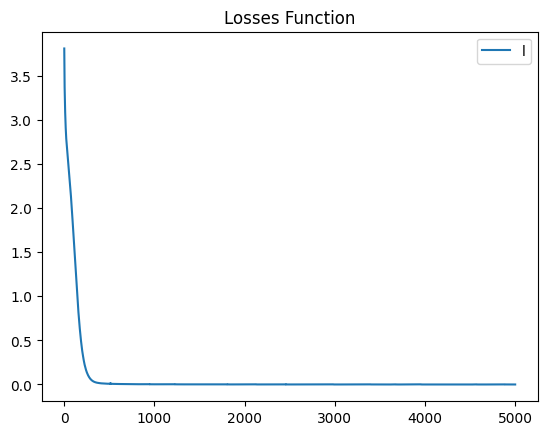

In [24]:
plt.plot(np.arange(0, epochs, 1), l_map, label = 'l')
plt.title('Losses Function')
plt.legend()
plt.show()

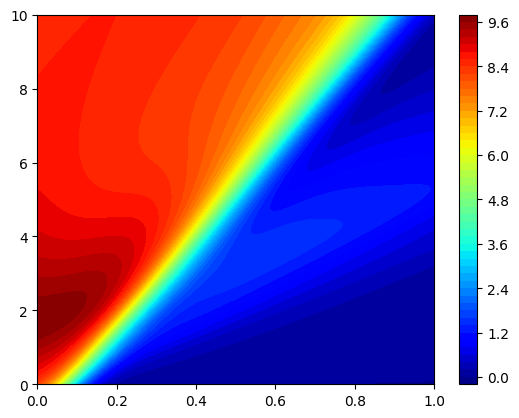

In [29]:
size = 1000
x_dom = (0, 1)
t_dom = (0, 10)
x = torch.linspace(x_dom[0], x_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
t = torch.linspace(t_dom[0], t_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
input = torch.cartesian_prod(x, t)
out = model(input)

x = x.cpu().detach().numpy()
t = t.cpu().detach().numpy()
out = out.cpu().detach().numpy()

X, T = np.meshgrid(x, t)
out = np.reshape(out, (size, size)).T

plt.contourf(X, T, out, levels = 50, cmap = 'jet')
plt.colorbar()


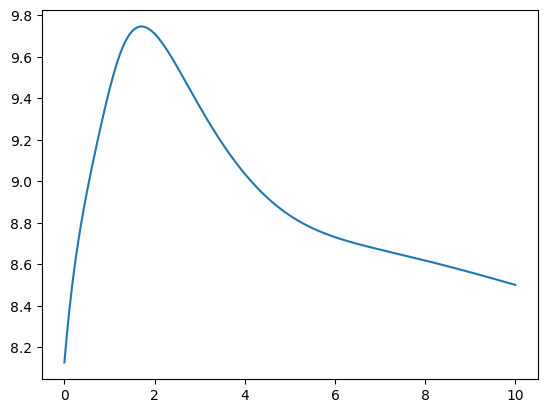

In [26]:
size = 1000
x = torch.tensor([0.]).to(device)
t = torch.linspace(t_dom[0], t_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
input = torch.cartesian_prod(x, t)
out = model(input)

t = t.cpu().detach().numpy()
out = out.cpu().detach().numpy()

plt.plot(t, out)

In [2]:
import deepxde as dde
import numpy as np
import torch

# Definição dos parâmetros do problema
D = 0.1  # Coeficiente de difusão
r_growth = 0.05  # Taxa de crescimento intrínseca
K = 1.0  # Capacidade de suporte

# Definição da equação de reação-difusão esférica
def reaction_diffusion_spherical(x, u):
    r, t = x[:, 0:1], x[:, 1:2]
    u_r = dde.grad.jacobian(u, x, i=0, j=0)
    u_rr = dde.grad.hessian(u, x, i=0, j=0)
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    reaction = r_growth * u * (1 - u / K)
    diffusion = D * (u_rr + 2 / r * u_r)
    return u_t - (diffusion + reaction)

# Domínio espacial e temporal
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 30)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condições iniciais e de fronteira
def boundary(_, on_initial):
    return on_initial

ic = dde.IC(geomtime, lambda x: np.exp(-5 * (x[:, 0:1]) ** 2), boundary)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

# Configuração do problema
data = dde.data.TimePDE(
    geomtime, reaction_diffusion_spherical, [ic, bc], num_domain=4000, num_boundary=100
)

# Definição da arquitetura da rede neural
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

# Usar PyTorch como backend
dde.backend.backend_name = "pytorch"

# Configuração do modelo PINN
model = dde.Model(data, net)

# Treinamento do modelo
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=5000)

# Avaliação do modelo
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
'compile' took 0.810712 s

Training model...



/home/henriquewsl/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'